In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sys
import time

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import PIL

from include import *
from pysit import *
from pysit.gallery import marmousi
from pysit.gallery import marmousi2

import deepwave

import models
import numpy as np
import random

import torch
import torch.optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

import scipy.ndimage


GPU = True
if GPU == True:
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(7)
    device = torch.device('cuda:7')  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

Total number of GPU available - 8


# Loading Data: FlatVel-A Dataset

In [2]:
amp_data = np.load('./CurveVel-A/amplitude/data1.npy')
vel_data = np.load('./CurveVel-A/velocity/model1.npy')

# converting to torch tensor
amp_data = torch.tensor(amp_data)
vel_data = torch.tensor(vel_data)

print('Shape of amplitude data - ', amp_data.shape)
print('Shape of velocity data - ', vel_data.shape)

# Taking random example from the dataset
index = random.randrange(0, 500)

vel_true = vel_data[index].squeeze().type(dtype).to(device)
amp_true = amp_data[index]

min_vel = torch.min(vel_true).cpu()
max_vel = torch.max(vel_true).cpu()

# Generating initial guess for ground truth velocity data
vp = scipy.ndimage.gaussian_filter(vel_true.cpu(),sigma=3).squeeze()

vp = torch.tensor(vp)

vp = (vp - min_vel)/(max_vel - min_vel)
vp = vp[None, None, ...].type(dtype).to(device)


Shape of amplitude data -  torch.Size([500, 5, 1000, 70])
Shape of velocity data -  torch.Size([500, 1, 70, 70])


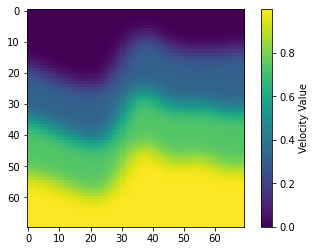

In [3]:
plt.imshow(vp[0,0].detach().cpu().numpy())
plt.colorbar(label="Velocity Value")
plt.show()

## Acquisition Setup


In [4]:
## Numbers are referred from the OpenFWI paper (OpenFWI: Large-Scale Multi-Structural Benchmark 
## Datasets for Seismic Full Waveform Inversion)

dx = 10
nz, ny = 70, 70

num_dims = 2
num_shots = 5

num_sources_per_shot = 1
source_spacing = 140

num_receivers_per_shot = 70
receiver_spacing = 10

peak_freq = 15
dt = 0.001 # 4ms

n_seconds = 1   # number of seconds receivers are recording
nt = int(n_seconds / dt) # number of time samples

In [5]:
#Build acquisition data

# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing

# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [6]:
num_channels = [1, 128, 128, 128, 128, 128, 1]
net = models.ConvolutionalNetwork(num_channels).type(dtype).to(device)

# conditional pre-training the random vector to learn the prior velocity guess
mse_n, mse_t, ni, _net = models.train(net, vp, vel_true, 
                                      5000, 1e-4, 'ADAM',
                                      batch_size=1,
                                      model_type='cnn',
                                      device = device) 

## FWI Optimization

In [7]:
# scale = torch.tensor(1000.).to(device)
# offset = torch.tensor(1500.).to(device)

# scale.requires_grad = True
# offset.requires_grad = True

params = [p for p in _net.parameters()]

# norm_param = [scale, offset]

l2_loss = torch.nn.MSELoss()
l1_loss = torch.nn.L1Loss()

# c1 = 0.7 and c2 = 0.3 give best result

c1 = 0.4 
c2 = 0.6

optimizer = torch.optim.Adam([{'params':params, 'lr':1e-4}])

In [8]:
# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
# This initial guess is shifted in frequency from the true one
source_amplitudes_init = (deepwave.wavelets.ricker(peak_freq, nt, dt, 1/peak_freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [9]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
# I take the absolute value of the maximum and add a small positive value
# (1e-10) to ensure that the denominator is never zero
rcv_amps_true_max, _ = amp_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = amp_true / (rcv_amps_true_max.abs() + 1e-10)

Model L2 Loss - 53573.96484375, 	 Model L1 Loss - 114.4590835571289




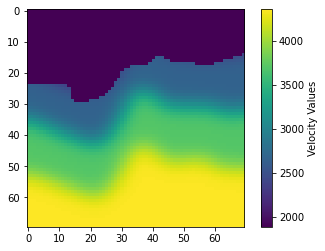

Model L2 Loss - 640730.5, 	 Model L1 Loss - 548.0279541015625




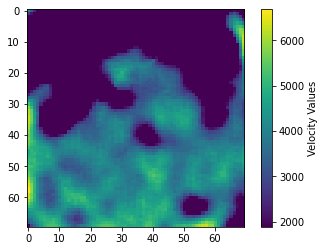

Model L2 Loss - 1069071.5, 	 Model L1 Loss - 692.90625




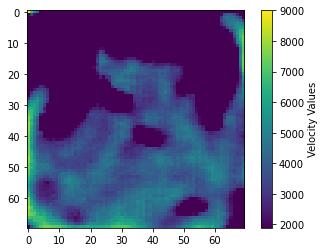

Model L2 Loss - 1391124.625, 	 Model L1 Loss - 769.0186767578125




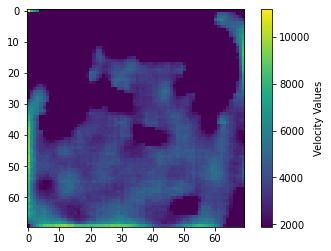

Model L2 Loss - 1507092.25, 	 Model L1 Loss - 794.7103881835938




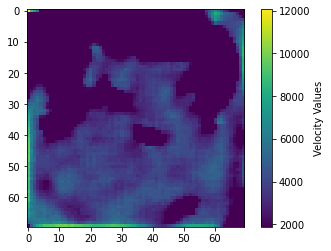

Model L2 Loss - 1541619.5, 	 Model L1 Loss - 816.5984497070312




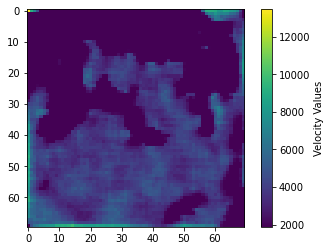

Model L2 Loss - 1631182.25, 	 Model L1 Loss - 844.17236328125




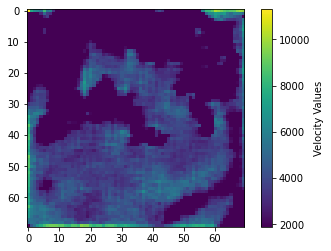

Model L2 Loss - 1881510.5, 	 Model L1 Loss - 880.876953125




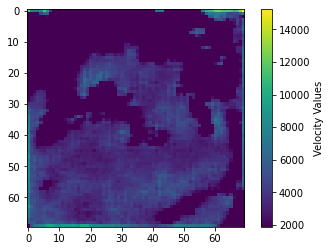

Model L2 Loss - 1909355.375, 	 Model L1 Loss - 897.28369140625




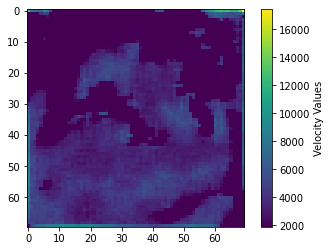

Model L2 Loss - 1998170.875, 	 Model L1 Loss - 906.9498901367188




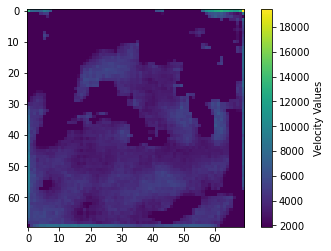

Runtime: 42.3435537815094


In [10]:
# Iterative inversion loop just FWI
t_start = time.time()
num_batches = 5 # split data into 10 batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
num_epochs = 100 # Pass through the entire dataset 30 times

scale = (max_vel - min_vel)
offset = min_vel


epoch_amp_loss_list=[]
model_l2_loss = []
model_l1_loss = []
count=0
   
for epoch in range(num_epochs):
    
    if(epoch%10 == 0):
        with torch.no_grad():
            norm_vel_var = _net(ni.type(dtype))        
            norm_vel_var = norm_vel_var.squeeze()
            norm_vel_np = norm_vel_var.data.cpu().numpy()
            
            norm_vel_var = torch.flatten(norm_vel_var)
            unnorm_vel_var = (scale)*norm_vel_var + (offset)

            unnorm_vel_var = unnorm_vel_var.reshape(70,70)
            
            curr_l2_loss = l2_loss(unnorm_vel_var, vel_true)
            curr_l1_loss = l1_loss(unnorm_vel_var, vel_true)
            
            print('Model L2 Loss - {curr_l2_loss}, \t Model L1 Loss - {curr_l1_loss}'.format(
                curr_l2_loss=curr_l2_loss, curr_l1_loss=curr_l1_loss))
            
            print('\n')
            
            model_l2_loss.append(curr_l2_loss.item())
            model_l1_loss.append(curr_l1_loss.item())
            
            plt.imshow(unnorm_vel_var.detach().cpu().numpy())
            plt.colorbar(label="Velocity Values")
            plt.show()
        
    epoch_loss2 = 0
    for it in range(num_batches):
        optimizer.zero_grad()
        
        norm_vel_var = _net(ni.type(dtype))
        norm_vel_var = norm_vel_var.squeeze()
        norm_vel_np = norm_vel_var.data.cpu().numpy()
    
        norm_vel_var = torch.flatten(norm_vel_var)
        unnorm_vel_var = (scale)*norm_vel_var + (offset)

        unnorm_vel_var = unnorm_vel_var.reshape(70,70)

        prop = deepwave.scalar.Propagator({'vp': unnorm_vel_var}, dx)
        batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true_norm[it::num_batches].to(device)
        
        batch_x_s = x_s[it::num_batches].to(device)
        batch_x_r = x_r[it::num_batches].to(device)
                
        batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
        
        # Normalize amplitudes by dividing by the maximum amplitude of each receiver
        batch_rcv_amps_pred_norm = batch_rcv_amps_pred / (batch_rcv_amps_pred_max.abs())
        
        loss1 = l1_loss(batch_rcv_amps_pred_norm, batch_rcv_amps_true)
        loss2 = l2_loss(batch_rcv_amps_pred_norm, batch_rcv_amps_true)
        
        pixel_loss = c1*loss1 + c2*loss2
        
        epoch_loss2 += pixel_loss.item()
        
        pixel_loss.backward()
        # print(epoch,'-', it, '-', pixel_loss.grad)
        optimizer.step()
    
    #scheduler.step()
    epoch_amp_loss_list.append(epoch_loss2)  

    
t_end = time.time()
print('Runtime:', t_end - t_start)

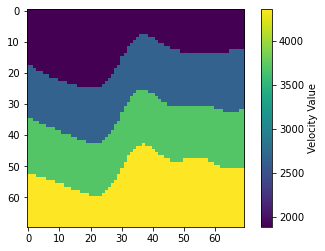

In [12]:
plt.imshow(vel_true.detach().cpu().numpy())
plt.colorbar(label="Velocity Value")
plt.show()

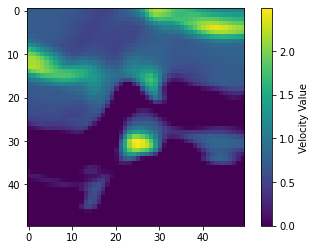

In [11]:
# normalized prediction
pred_vel = net(vp)

plt.imshow(pred_vel[0,0].detach().cpu().numpy())
plt.colorbar(label="Velocity Value")
plt.show()

In [13]:
pred_vel = pred_vel*scale + offset

Ground Truth


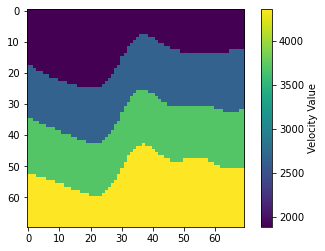

Prediction


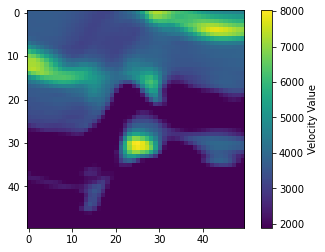

In [14]:
# unnormalized prediction
print("Ground Truth")
plt.imshow(vel_true.detach().cpu().numpy())
plt.colorbar(label="Velocity Value")
plt.show()

print("Prediction")
plt.imshow(pred_vel[0,0].detach().cpu().numpy())
plt.colorbar(label="Velocity Value")
plt.show()